# Texi Demand Prediction

There are roughly 200 million taxi rides in New York City each year. Exploiting an understanding of taxi supply and demand could increase the efficiency of the city’s taxi system. In the New York city, people use taxi in a frequency much higher than any other cities of US. Instead of booking a taxi by phone one day ahead of time, New York taxi drivers pick up passengers on street. The ability to predict taxi ridership could present valuable insights to city planners and taxi dispatchers in answering questions such as how to position cabs where they are most needed, how many taxis to dispatch, and how ridership varies over time. Our project focuses on predicting the number of taxi pickups given a one-hour time window and a location within New York City.

#### Input: 
We giving the time and the location of the puckup.
#### Output:
Predicting the number of pickups in the given time interval.

In [1]:
# we importing all the important libraries
import pandas as pd
import numpy as np
import seaborn as sb 
import matplotlib.pyplot as plt
import dask.dataframe as dd
import folium
import time 
import datetime
import sqlite3
from sklearn.cluster import MiniBatchKMeans
# importing gpxpy file for working with gpx data
import gpxpy
import math

## Data Source

we generally tke ready made dataset from the kaggle
but here, we extract data from the new york texi portal
datastet is in csv files.
Source => https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page
we are using yellow texis data for our model building

The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP). The trip data was not created by the TLC, and TLC makes no representations as to the accuracy of these data.

In [2]:
# we have a large size of dataset which is about 2 GBs data size,
# we will use pandas like python library dask which creates a chunks of data which helps,
# to execute large files into the ram.
# dask dataframe  : # https://github.com/dask/dask-tutorial/blob/master/07_dataframe.ipynb
texi_df = dd.read_csv('yellow_tripdata_2015-01.csv')

### Features in dataset
<table border="1">
	<tr>
		<th>Field Name</th>
		<th>Description</th>
	</tr>
	<tr>
		<td>VendorID</td>
		<td>
		A code indicating the TPEP provider that provided the record.
		<ol>
			<li>Creative Mobile Technologies</li>
			<li>VeriFone Inc.</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>tpep_pickup_datetime</td>
		<td>The date and time when the meter was engaged.</td>
	</tr>
	<tr>
		<td>tpep_dropoff_datetime</td>
		<td>The date and time when the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Passenger_count</td>
		<td>The number of passengers in the vehicle. This is a driver-entered value.</td>
	</tr>
	<tr>
		<td>Trip_distance</td>
		<td>The elapsed trip distance in miles reported by the taximeter.</td>
	</tr>
	<tr>
		<td>Pickup_longitude</td>
		<td>Longitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>Pickup_latitude</td>
		<td>Latitude where the meter was engaged.</td>
	</tr>
	<tr>
		<td>RateCodeID</td>
		<td>The final rate code in effect at the end of the trip.
		<ol>
			<li> Standard rate </li>
			<li> JFK </li>
			<li> Newark </li>
			<li> Nassau or Westchester</li>
			<li> Negotiated fare </li>
			<li> Group ride</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Store_and_fwd_flag</td>
		<td>This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		<br\>Y= store and forward trip
		<br\>N= not a store and forward trip
		</td>
	</tr>

	<tr>
		<td>Dropoff_longitude</td>
		<td>Longitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Dropoff_ latitude</td>
		<td>Latitude where the meter was disengaged.</td>
	</tr>
	<tr>
		<td>Payment_type</td>
		<td>A numeric code signifying how the passenger paid for the trip.
		<ol>
			<li> Credit card </li>
			<li> Cash </li>
			<li> No charge </li>
			<li> Dispute</li>
			<li> Unknown </li>
			<li> Voided trip</li>
		</ol>
		</td>
	</tr>
	<tr>
		<td>Fare_amount</td>
		<td>The time-and-distance fare calculated by the meter.</td>
	</tr>
	<tr>
		<td>Extra</td>
		<td>Miscellaneous extras and surcharges. Currently, this only includes. the $0.50 and $1 rush hour and overnight charges.</td>
	</tr>
	<tr>
		<td>MTA_tax</td>
		<td>0.50 MTA tax that is automatically triggered based on the metered rate in use.</td>
	</tr>
	<tr>
		<td>Improvement_surcharge</td>
		<td>0.30 improvement surcharge assessed trips at the flag drop. the improvement surcharge began being levied in 2015.</td>
	</tr>
	<tr>
		<td>Tip_amount</td>
		<td>Tip amount – This field is automatically populated for credit card tips.Cash tips are not included.</td>
	</tr>
	<tr>
		<td>Tolls_amount</td>
		<td>Total amount of all tolls paid in trip.</td>
	</tr>
	<tr>
		<td>Total_amount</td>
		<td>The total amount charged to passengers. Does not include cash tips.</td>
	</tr>
</table>

In [7]:
print(texi_df.columns)
texi_df.tpep_pickup_datetime[:10000000000]

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


Dask Series Structure:
npartitions=60
    object
       ...
     ...  
       ...
       ...
Name: tpep_pickup_datetime, dtype: object
Dask Name: try_loc, 180 tasks

In [9]:
 texi_df.shape

(Delayed('int-5b43102a-b5a1-4f4e-ad81-553fb4cca725'), 19)

In [6]:
# to see the visualization of the dataset
# we need to install graphviz library
!pip install graphviz

You should consider upgrading via the '/home/nural/notebook/jupyterenv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# how the dataset is sotred in the ram in the chunks of data
# see the visulaization here,
texi_df.visualize()

## Map of New York city street

Here we plot the map of newyork city with the raw data, ther are some outliers in the raw data which are pointing outside of the newyork city
The latitude of New York City Hall, NY, USA is 40.712772, and the longitude is -74.006058. New York City Hall, NY, USA is located at United States country in the Notable Buildings place category with the gps coordinates of 40° 42' 45.9792'' N and 74° 0' 21.8088'' W.

Latitude and longitude coordinates are: 40.712772, -74.006058.


In [9]:
pip install folium

     |████████████████████████████████| 95 kB 242 kB/s eta 0:00:01
You should consider upgrading via the '/home/nural/notebook/jupyterenv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Pickup longitude &
# pickup latitude

# there are may outliers present in the raw longituted and latitude data which we have to see
Outliers_pickups = texi_df[((texi_df.pickup_longitude <= -74.15) | (texi_df.pickup_latitude <= 40.5774)| \
                   (texi_df.pickup_longitude >= -73.7004) | (texi_df.pickup_latitude >= 40.9176))] 

# for ploting the map we have to install the folium python library
# !pip install folium
mp = folium.Map(location=[40.712772, -74.006058])
# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample = Outliers_pickups.head(10000)
for i,j in sample.iterrows():
    if int(j['pickup_latitude']) != 0:
        folium.Marker(list((j['pickup_latitude'],j['pickup_longitude']))).add_to(mp)
mp
# map shows the outlier pickups outside the new york city area

/home/nural/notebook/jupyterenv/lib/python3.8/site-packages/dask/dataframe/core.py:7010: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 4071 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


In [4]:
# dropoff longitude &
# dropoff latitude

# there are may outliers present in the raw longituted and latitude data which we have to see
Outliers_pickups = texi_df[((texi_df.dropoff_longitude <= -74.15) | (texi_df.dropoff_latitude <= 40.5774)| \
                   (texi_df.dropoff_longitude >= -73.7004) | (texi_df.dropoff_latitude >= 40.9176))] 

# for ploting the map we have to install the folium python library
# !pip install folium
mp = folium.Map(location=[40.712772, -74.006058])
# we will spot only first 100 outliers on the map, plotting all the outliers will take more time
sample = Outliers_pickups.head(1000)
for i,j in sample.iterrows():
    if int(j['dropoff_latitude']) != 0:
        folium.Marker(list((j['dropoff_latitude'],j['dropoff_longitude']))).add_to(mp)
mp
# map shows the outlier dropoffs outside the new york city area
# these are considered as outliers

In [29]:
print(texi_df.columns)
texi_df.head()

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


In [ ]:
# first we have to convert the date time timestamp into the unix time stamp
# more about unix timestamp refer this:
# https://www.unixtimestamp.com/
# https://stackoverflow.com/questions/19801727/convert-datetime-to-unix-timestamp-and-convert-it-back-in-python
pickup_time = []
dropoff_time = []
format = "%Y-%m-%d %H:%M:%S"
for i in texi_df['tpep_pickup_datetime']:
    pickup_time.append(time.mktime(datetime.datetime.strptime(i,format).timetuple()))
for i in texi_df['tpep_dropoff_datetime']:
    dropoff_time.append(time.mktime(datetime.datetime.strptime(i,format).timetuple()))

In [10]:
# above command take much time so we store list values into the database
df = pd.DataFrame({'pickup_time':pickup_time, 'dropoff_time':dropoff_time})
connection = sqlite3.connect('Time_list.db')
c = connection.cursor()
df.to_sql('Table1',connection)
connection.close()

Now we remove the unwanted columns or the columns which are not giving importance in the model building process, apart from that we are building the new dataframe which contain all the new features which we required for the model building. 


In [3]:
c = sqlite3.connect('Time_list.db')
s = pd.read_sql('SELECT * FROM Table1',c)
pickup_time = s['pickup_time']
dropoff_time = s['dropoff_time']

In [4]:
# making new DataFrame
# construct New features,
# 1. Trip_duration
# 2. Speed
# 3. Pickup_time
new_df = texi_df[['passenger_count','trip_distance','pickup_longitude','pickup_latitude',
                  'dropoff_longitude','dropoff_latitude','total_amount']].compute()
def new_dataframe():
    durations = (np.array(dropoff_time) - np.array(pickup_time))/float(60)
    # creating trip duration
    new_df['trip_duration'] = durations
    # creating speed column ==> speed = distane/time
    new_df['speed'] = (new_df['trip_distance']/ new_df['trip_duration'])*60
    # creating pickup_time
    new_df['pickup_time'] = pickup_time

new_dataframe()

In [5]:
new_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,speed,pickup_time
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,5.285319,1.421329e+09
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,9.983193,1.420902e+09
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,10.746269,1.420902e+09
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,16.071429,1.420902e+09
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,9.318378,1.420902e+09


In [9]:
new_df.shape

(12748986, 10)

## Outliers in trip_duration

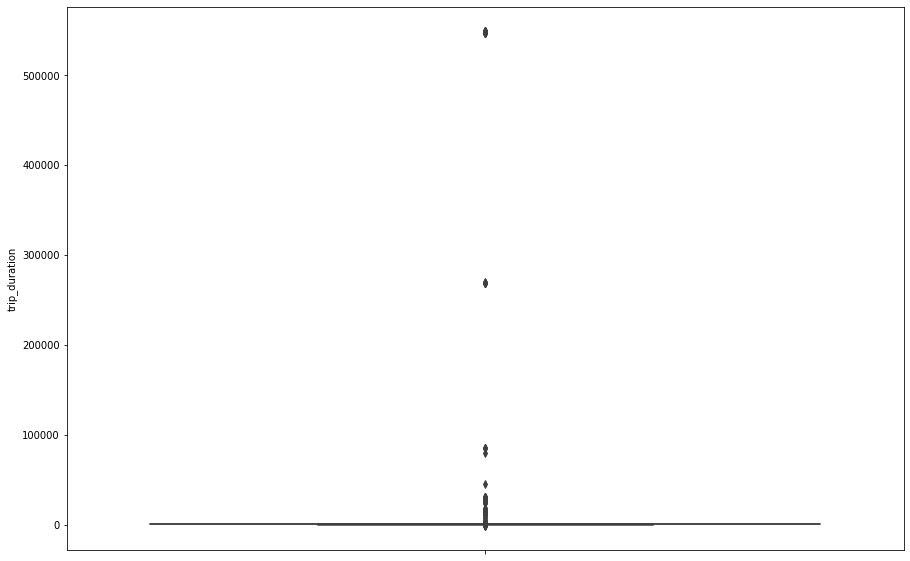

In [10]:
# we plot the box plot of trip_duration to visualize the outliers in the data
plt.figure(figsize=[15,10])
sb.boxplot(y = new_df.trip_duration)
plt.show()

<p style="font-size:18px">According to NYC Taxi &amp; Limousine Commision Regulations <b style= "color:black">the maximum allowed trip duration in a 24 hour interval is 12 hours.</b> </p>

In [11]:
# we observ that there is bunch of points which are outliers in the data
# and the most of the values are lie b/w 25% 50% 75% 
# here we take a close look of trip distance b/w the percentiles
for i in range(0,100,10):
    print('The {} percentile trp duration value is: '.format(i),np.percentile(new_df.trip_duration,i))

The 0 percentile trp duration value is:  -1211.0166666666667
The 10 percentile trp duration value is:  3.8333333333333335
The 20 percentile trp duration value is:  5.383333333333334
The 30 percentile trp duration value is:  6.816666666666666
The 40 percentile trp duration value is:  8.3
The 50 percentile trp duration value is:  9.95
The 60 percentile trp duration value is:  11.866666666666667
The 70 percentile trp duration value is:  14.283333333333333
The 80 percentile trp duration value is:  17.633333333333333
The 90 percentile trp duration value is:  23.45


In [6]:
# we see that there is missrable values are present, like in 0th percentile value is in -ve
# as per as maximum trip duration time is 12 hours and min is 0.
# so we will remove all the outliers from the trip_duration data
new_df2 = new_df[(new_df.trip_duration>1 )&(new_df.trip_duration<=720)] 

In [8]:
new_df2.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,speed,pickup_time
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,5.285319,1.421329e+09
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,9.983193,1.420902e+09
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,10.746269,1.420902e+09
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,16.071429,1.420902e+09
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,9.318378,1.420902e+09


/home/nural/notebook/jupyterenv/lib/python3.8/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1008x720 with 0 Axes>

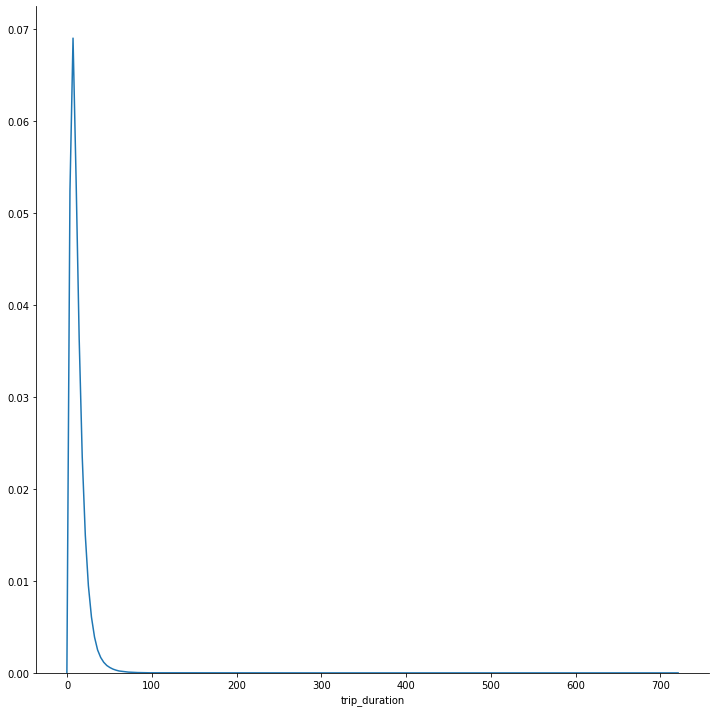

In [9]:
# we plot a PDF of trip_duration
plt.figure(figsize=[14,10])
sb.FacetGrid(new_df2,size=10).map(sb.kdeplot,'trip_duration').add_legend();
plt.show()

In [ ]:
# oberve that this is a skiwed distributed
# we see in the distribution that the right side is slowly tapering off, 
#so this is not a gaussian distribution

## Outliers in speed

<AxesSubplot:ylabel='speed'>

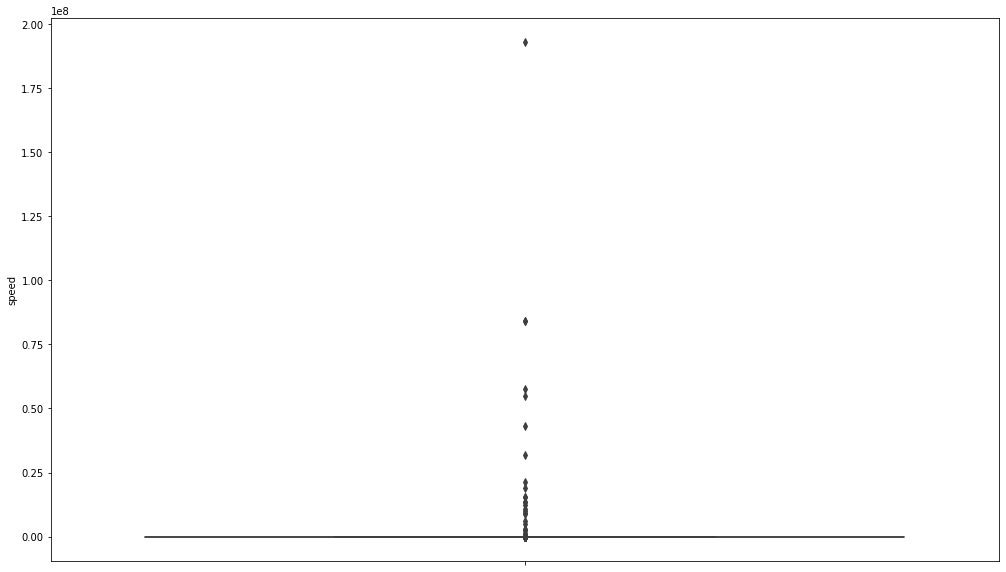

In [10]:
# ploting box plot for outlier visualization
plt.figure(figsize=[17,10])
sb.boxplot(y=new_df2.speed)

In [11]:
# we observ that there is bunch of points which are outliers in the data
# and the most of the values are lie b/w 25% 50% 75% 
# here we take a close look of trip distance b/w the percentiles
for i in range(0,110,10):
    print('The {} percentile trp duration value is: '.format(i),np.percentile(new_df2.speed,i))

The 0 percentile trp duration value is:  0.0
The 10 percentile trp duration value is:  6.409495548961425
The 20 percentile trp duration value is:  7.80952380952381
The 30 percentile trp duration value is:  8.929133858267717
The 40 percentile trp duration value is:  9.98019801980198
The 50 percentile trp duration value is:  11.06865671641791
The 60 percentile trp duration value is:  12.286689419795222
The 70 percentile trp duration value is:  13.796407185628745
The 80 percentile trp duration value is:  15.963224893917962
The 90 percentile trp duration value is:  20.186915887850468
The 100 percentile trp duration value is:  192857142.85714284


In [12]:
# taking the 91% to 100%
for i in range(91,101):
    print('The {} percentile trp duration value is: '.format(i),np.percentile(new_df2.speed,i))

The 91 percentile trp duration value is:  20.916454400875093
The 92 percentile trp duration value is:  21.752988047808763
The 93 percentile trp duration value is:  22.721893491124263
The 94 percentile trp duration value is:  23.844155844155843
The 95 percentile trp duration value is:  25.182552504038775
The 96 percentile trp duration value is:  26.80851063829787
The 97 percentile trp duration value is:  28.84304932735426
The 98 percentile trp duration value is:  31.591128254580514
The 99 percentile trp duration value is:  35.75135055113604
The 100 percentile trp duration value is:  192857142.85714284


In [148]:
# when we observe that the 100th percentile value is too large which is obvious an outlier
# we have to remove such outliers from data
new_df2 = new_df[(new_df.speed>0)&(new_df.speed<45.31)]

In [150]:
# taking average of speed 
avg = sum(new_df2.speed)/len(new_df2.speed)
print('the average speed of taxi driver in NYC: ',avg)

TypeError: 'int' object is not callable

The average speed was calculated as trip distance/trip time. For all taxi trips, the mean speed was 14.0 MPH, with a standard deviation of 6.2 MPH. The median speed was 12.7 MPH, with 95% of all trips falling between 5.9 to 30.0 MPH

So, we say that average speed will be 12.45 MPH, and the texi taravel in 10 min of interval 2 miles average.
<p><b style='color:red'>That's why we are choosing the 10 min. interval for prediction</p>

## Outliers in trip_distance

<AxesSubplot:ylabel='trip_distance'>

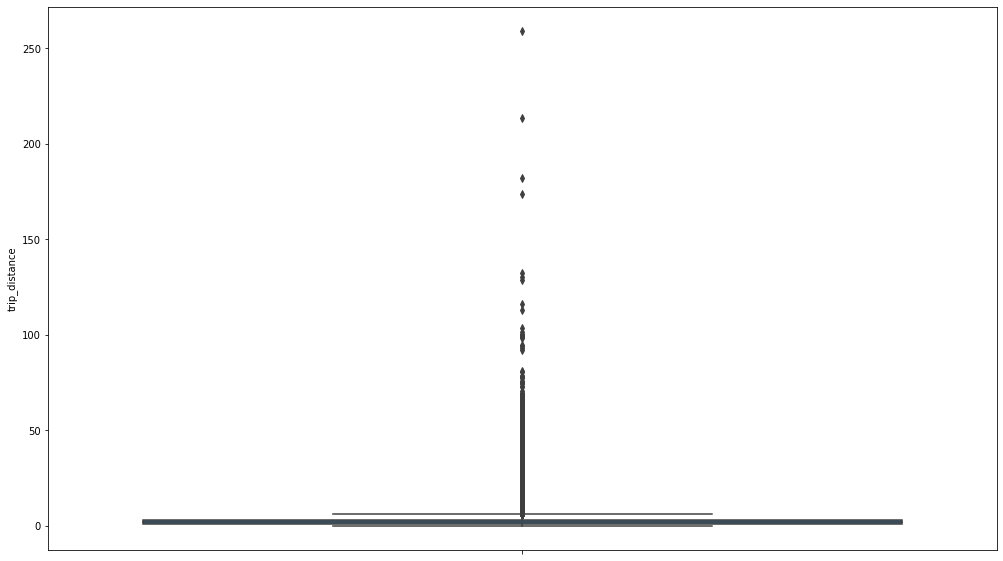

In [15]:
# ploting box plot for outlier visualization
plt.figure(figsize=[17,10])
sb.boxplot(y=new_df2.trip_distance)

In [16]:
# we observ that there is bunch of points which are outliers in the data
# and the most of the values are lie b/w 25% 50% 75% 
# here we take a close look of trip distance b/w the percentiles
for i in range(0,110,10):
    print('The {} percentile trp duration value is: '.format(i),np.percentile(new_df2.trip_distance,i))

The 0 percentile trp duration value is:  0.01
The 10 percentile trp duration value is:  0.66
The 20 percentile trp duration value is:  0.9
The 30 percentile trp duration value is:  1.1
The 40 percentile trp duration value is:  1.39
The 50 percentile trp duration value is:  1.69
The 60 percentile trp duration value is:  2.07
The 70 percentile trp duration value is:  2.6
The 80 percentile trp duration value is:  3.6
The 90 percentile trp duration value is:  5.97
The 100 percentile trp duration value is:  258.9


In [17]:
# checking outlier b/w 91 to 100 percentile
for i in range(91,101):
    print('The {} percentile trp duration value is: '.format(i),np.percentile(new_df2.trip_distance,i))

print('***************************percentiles values b/w 99 to 100**************************')
for i in np.arange(0.0,1.0,0.1):
    print('The {} percentile trp duration value is: '.format(99+i),np.percentile(new_df2.trip_distance,99+i))

The 91 percentile trp duration value is:  6.45
The 92 percentile trp duration value is:  7.07
The 93 percentile trp duration value is:  7.85
The 94 percentile trp duration value is:  8.72
The 95 percentile trp duration value is:  9.6
The 96 percentile trp duration value is:  10.6
The 97 percentile trp duration value is:  12.1
The 98 percentile trp duration value is:  16.03
The 99 percentile trp duration value is:  18.17
The 100 percentile trp duration value is:  258.9
***************************percentiles values b/w 99 to 100**************************
The 99.0 percentile trp duration value is:  18.17
The 99.1 percentile trp duration value is:  18.37
The 99.2 percentile trp duration value is:  18.6
The 99.3 percentile trp duration value is:  18.83
The 99.4 percentile trp duration value is:  19.13
The 99.5 percentile trp duration value is:  19.5
The 99.6 percentile trp duration value is:  19.96
The 99.7 percentile trp duration value is:  20.5
The 99.8 percentile trp duration value is:  

In [5]:
# Now we create a function which helps to remove the outilier from all the data
# that we have observe in following columns
# we remove ouliers from all the columns and store it into new dataframe
def remove_outliers(dataframe):
    modified_df = dataframe[((dataframe.pickup_longitude >= -74.15) & (dataframe.pickup_latitude >= 40.5774) &
                   (dataframe.pickup_longitude <= -73.7004) & (dataframe.pickup_latitude <= 40.9176))&
                   ((dataframe.dropoff_longitude >= -74.15) & (dataframe.dropoff_latitude >= 40.5774) &
                   (dataframe.dropoff_longitude <= -73.7004) & (dataframe.dropoff_latitude <= 40.9176))]

    modified_df = modified_df[(modified_df.speed>0)&(modified_df.speed<45.31)]
    modified_df = modified_df[(modified_df.trip_duration>=1)&(modified_df.trip_duration<720)]
    modified_df = modified_df[(modified_df.trip_distance>0)&(modified_df.trip_distance<23)]
    modified_df = modified_df[(modified_df.total_amount>0)&(modified_df.total_amount<1000)]
    
    return modified_df

modified_df = remove_outliers(new_df)
# checking the amount of data removed from the previous data
print('the amount of data remains: ',float(len(modified_df)/len(new_df)))

the amount of data remains:  0.968340462527765


In [20]:
modified_df.shape

(12345359, 10)

# Data Preperation


Now this is the step where we have to divide our city into the regions, but there is some question regarding it,
1.on what features we are dividing clusters, basically it wa longitude and latitude

we are using k-means for the clustering formation, but on what factorwe decide the optimal value of k...
Based on some constraints we decide the optimal value of K:
----------inter cluster distance should be < 2(miles)   #cover 2 miles in 10 min of interval
----------inter cluster distance should be >0.5(miles)  # for small regions creation.

## creation of regions and choosing optimal k

In [7]:
# create a function which chooses the optimal value of k
neighbor = []

def cluster_creation(i):
    # i used for experiment with diff. numbers of clusters
    cluster = MiniBatchKMeans(n_clusters=i, batch_size=10000, random_state=42)
    cluster.fit(modified_df[['pickup_latitude','pickup_longitude']].values)
    # store the predicted cluster and centroids into the new columns
    modified_df['pickup_clusters'] = cluster.predict(modified_df[['pickup_latitude', 'pickup_longitude']])
    cluster_center = cluster.cluster_centers_
    
    # return the len of cluster center and cluster_center
    return cluster_center, len(cluster_center)

def cluster_distance(cluster_center, cluster_len):
    inrange = []
    min_dist = 1000  
    count = 0
    for i in range(cluster_len):
        count = 0
        for j in range(cluster_len):
            if j!=i:
                #https://github.com/tkrajina/gpxpy/blob/dev/gpxpy/geo.py read for gpxpy library
                # using the harvesing distance for finding the distance b/w two clusters
                distance = gpxpy.geo.haversine_distance(cluster_center[i][0],cluster_center[i][1],
                                                  cluster_center[j][0],cluster_center[j][1])
                # our constraints,
                # ----inter cluster distance is <=2
                # ----inter cluster distance is >=0.5
                min_dist = min(min_dist, distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <=2:    #(1.60934*1000) used for converting the km into m
                    count+=1

        inrange.append(count)
    neighbor.append(inrange)
    print('cluster size of:{}'.format(cluster_len),'\nAverage number of clusters which have inter cluster distance >=2 : ',np.ceil(sum(inrange)/len(inrange)))
    print('minimum inter cluster distance: ',min_dist)

for i in range(10,100,15):
    cluster_center, cluster_len = cluster_creation(i)
    cluster_distance(cluster_center, cluster_len)

cluster size of:10 
Average number of clusters which have inter cluster distance >=2 :  2.0
minimum inter cluster distance:  0.9444222536355648
cluster size of:25 
Average number of clusters which have inter cluster distance >=2 :  7.0
minimum inter cluster distance:  0.5225771201470653
cluster size of:40 
Average number of clusters which have inter cluster distance >=2 :  9.0
minimum inter cluster distance:  0.42816814149605265
cluster size of:55 
Average number of clusters which have inter cluster distance >=2 :  14.0
minimum inter cluster distance:  0.33779970869430564
cluster size of:70 
Average number of clusters which have inter cluster distance >=2 :  20.0
minimum inter cluster distance:  0.270930479562957
cluster size of:85 
Average number of clusters which have inter cluster distance >=2 :  23.0
minimum inter cluster distance:  0.2437064175082514


The optimal value of k in kmeans is 25, because nearly 28% of the clusters are in 2 miles range and having minimum inter cluster distance is greater then 0.5

In [6]:
# iniltialization of kmeans with 25 as n_clusters
# using 25 as a n_clusters
kmeans = MiniBatchKMeans(n_clusters= 25, batch_size=10000, random_state=0)
kmeans.fit(modified_df[['pickup_latitude','pickup_longitude']].values)
# store the predicted cluster and centroids into the new columns
modified_df['pickup_clusters'] = kmeans.predict(modified_df[['pickup_latitude', 'pickup_longitude']])

In [7]:
cluster_center = kmeans.cluster_centers_
cluster_len = len(cluster_center)

### Ploting the map with the cluster centers

In [60]:
plt.figure(figsize=[18,9])
maps = folium.Map(location=[40.734695, -73.990372])
for i in range(cluster_len):
    folium.Marker(list((cluster_center[i][0],cluster_center[i][1])), popup=(str(cluster_center[i][0])+str(cluster_center[i][1]))).add_to(maps)
maps

<Figure size 1296x648 with 0 Axes>

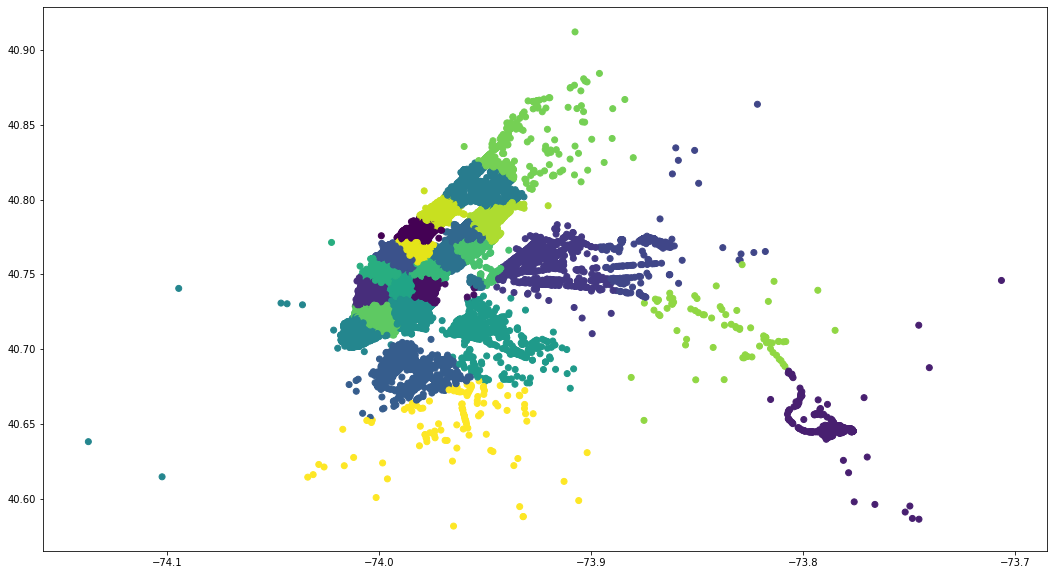

In [64]:
plt.figure(figsize=[18,10])
plt.scatter(y= modified_df.pickup_latitude[:100000],x= modified_df.pickup_longitude[:100000],
            c= modified_df.pickup_clusters[:100000])

In [100]:
modified_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,speed,pickup_time,pickup_clusters,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,5.285319,1.421329e+09,15,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,9.983193,1.420902e+09,18,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,10.746269,1.420902e+09,10,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,16.071429,1.420902e+09,11,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,9.318378,1.420902e+09,9,1419


## Creating time bins

In [10]:
# we have to create a time interval of 10 mins, of our unix timestamp
# unix timestamp is in seconds, 10min = 600sec. so we have to divide unix time with 600. (unix_time/600)
# we create the 10min inerval beans on basis of month
def create_bins(frame,month,year):
    # unix time of start of each month jan,feb,march,april,may,june of 2015 and 2016
    # ex--> 1420070400 belongs to 2015 1st,jan.....1422748800 belongs to 2015 1st feb....so on..
    month_start_unixs = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],
                         [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    start_pickup = month_start_unixs[year-2015][month-1]
    # out unix time is in gmt, we converted into est time zone because we have NYC time
    frame['pickup_bins'] = np.array([(int((i-start_pickup)/600)+33) for i in frame.pickup_time])
    return frame


In [11]:
jan2015_df = create_bins(modified_df,1,2015)

In [12]:
jan2015_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,speed,pickup_time,pickup_clusters,pickup_bins
0,1,1.59,-73.993896,40.750111,-73.974785,40.750618,17.05,18.050000,5.285319,1.421329e+09,15,2130
1,1,3.30,-74.001648,40.724243,-73.994415,40.759109,17.80,19.833333,9.983193,1.420902e+09,18,1419
2,1,1.80,-73.963341,40.802788,-73.951820,40.824413,10.80,10.050000,10.746269,1.420902e+09,10,1419
3,1,0.50,-74.009087,40.713818,-74.004326,40.719986,4.80,1.866667,16.071429,1.420902e+09,11,1419
4,1,3.00,-73.971176,40.762428,-74.004181,40.742653,16.30,19.316667,9.318378,1.420902e+09,9,1419


In [13]:
jan2015_groupby = jan2015_df[['pickup_clusters','pickup_bins','trip_distance']].groupby(['pickup_clusters','pickup_bins'])
jan2015_groupby = jan2015_groupby.count()

In [13]:
jan2015_groupby

trip_distance
pickup_clusters pickup_bins               
0               1                      224
                2                      231
                3                      235
                4                      223
                5                      208
...                                    ...
24              4459                    10
                4460                     9
                4461                     3
                4462                     2
                4463                     5

[48446 rows x 1 columns]

In [14]:
# we have to perform all the preprocessing on 2016 data same as we perform on 2015
# create a function which will process the data of 2016 jan, feb and march months
def convert_unix(frame):  #convert timestamp into unix of new year and month
    pickup_time = []
    dropoff_time = []
    format = "%Y-%m-%d %H:%M:%S"
    for i in frame['tpep_pickup_datetime']:
        pickup_time.append(time.mktime(datetime.datetime.strptime(i,format).timetuple()))
    for i in frame['tpep_dropoff_datetime']:
        dropoff_time.append(time.mktime(datetime.datetime.strptime(i,format).timetuple()))
    return pickup_time, dropoff_time


def new_dataframe(frame):  #creating new_datframe into unix of new year and month
    
    pickup_time, dropoff_time = convert_unix(frame)    #calling convert_unix
    frame2 = frame[['passenger_count','trip_distance','pickup_longitude','pickup_latitude',
                  'dropoff_longitude','dropoff_latitude','total_amount']].compute()
    durations = (np.array(dropoff_time) - np.array(pickup_time))/float(60)
    # creating trip duration
    frame2['trip_duration'] = durations
    # creating speed column ==> speed = distane/time
    frame2['speed'] = (frame2['trip_distance']/ frame2['trip_duration'])*60
    # creating pickup_time
    frame2['pickup_time'] = pickup_time
    
    return frame2

# Now we create a function which helps to remove the outilier from all the data
def remove_outliers(dataframe):
    modified_df = dataframe[((dataframe.pickup_longitude >= -74.15) & (dataframe.pickup_latitude >= 40.5774) &
                   (dataframe.pickup_longitude <= -73.7004) & (dataframe.pickup_latitude <= 40.9176))&
                   ((dataframe.dropoff_longitude >= -74.15) & (dataframe.dropoff_latitude >= 40.5774) &
                   (dataframe.dropoff_longitude <= -73.7004) & (dataframe.dropoff_latitude <= 40.9176))]

    modified_df = modified_df[(modified_df.speed>0)&(modified_df.speed<45.31)]
    modified_df = modified_df[(modified_df.trip_duration>=1)&(modified_df.trip_duration<720)]
    modified_df = modified_df[(modified_df.trip_distance>0)&(modified_df.trip_distance<23)]
    modified_df = modified_df[(modified_df.total_amount>0)&(modified_df.total_amount<1000)]
    
    return modified_df


# now we preprocess remaining csv files...
def data_preprocessing(frame,month_no,year_no):
    # creating new dataframe 
    modified_df = new_dataframe(frame)
    # removinf outliers
    modified_df = remove_outliers(modified_df)
    # creating pickups clusters
    modified_df['pickup_clusters'] = kmeans.predict(modified_df[['pickup_latitude', 'pickup_longitude']])
    final_df = create_bins(modified_df,month_no,year_no)
    final_groupby_df = final_df[['pickup_clusters','pickup_bins','trip_distance']
                                ].groupby(['pickup_clusters','pickup_bins']).count()
    
    return final_df, final_groupby_df

jan2016 = dd.read_csv('yellow_tripdata_2016-01.csv')
feb2016 = dd.read_csv('yellow_tripdata_2016-02.csv')
mar2016 = dd.read_csv('yellow_tripdata_2016-03.csv')

jan2016_df, jan2016_groupby = data_preprocessing(jan2016,1,2016)
feb2016_df, feb2016_groupby = data_preprocessing(feb2016,2,2016)
mar2016_df, mar2016_groupby = data_preprocessing(mar2016,3,2016)
        

In [15]:
jan2016_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,trip_duration,speed,pickup_time,pickup_clusters,pickup_bins
5,2,5.52,-73.980118,40.743050,-73.913490,40.763142,20.3,18.50,17.902703,1.451587e+09,1,0
6,2,7.45,-73.994057,40.719990,-73.966362,40.789871,27.3,26.75,16.710280,1.451587e+09,18,0
7,1,1.20,-73.979424,40.744614,-73.992035,40.753944,10.3,11.90,6.050420,1.451587e+09,1,1
8,1,6.00,-73.947151,40.791046,-73.920769,40.865578,19.3,11.20,32.142857,1.451587e+09,21,1
9,1,3.21,-73.998344,40.723896,-73.995850,40.688400,12.8,11.10,17.351351,1.451587e+09,18,1


You observe that in the pickup_bins, which is divided into 10 min of intervals, there is sometimes value is 0. which is not appropriate...so we have to modify this!

In [16]:
# For solving this zero pickup error we will assign the weight of neighbors of the zero pickup
# first we will creating the list of zero pickups for each of the clusters

def creating_zero_pickups_list(frame):
    values = []
    for i in range(0,25):
        new_df = frame[frame.pickup_clusters==i]
        lis = list(set(new_df.pickup_bins))
        values.append(lis)
    return values

jan2015_unique = creating_zero_pickups_list(jan2015_df)
jan2016_unique = creating_zero_pickups_list(jan2016_df)
feb2016_unique = creating_zero_pickups_list(feb2016_df)
mar2016_unique = creating_zero_pickups_list(mar2016_df)

In [17]:
def fill_missing(groupby_values, unique_values):
    smooth_data = []
    index = 0
    for i in range(25):
        smooth_values=[]
        for j in range(4464):
            if j in unique_values[i]:
                smooth_values.append(groupby_values[index])
                index+=1
            else:
                smooth_values.append(0)
        smooth_data.extend(smooth_values)
    return smooth_data


# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the groupby_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(groupby_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(25):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(groupby_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=groupby_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(groupby_values[ind-1]+groupby_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=groupby_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [18]:
# so we use smoothing for jan 2015th data since it acts as our training data
# and we use simple fill_misssing method for 2016th data.

# we will smooth only 2015 data
jan2015_smooth = smoothing(jan2015_groupby.trip_distance.values, jan2015_unique)
# we fill zero value in the missing data of 2016 data
jan2016_smooth = fill_missing(jan2016_groupby.trip_distance.values, jan2016_unique)
feb2016_smooth = fill_missing(feb2016_groupby.trip_distance.values, feb2016_unique)
mar2016_smooth = fill_missing(mar2016_groupby.trip_distance.values, mar2016_unique)

In [19]:
# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
# use 2016 data olny
regions_cum = []
for i in range(25):
    jan = jan2016_smooth[4464*i:4464*(i+1)]
    feb = feb2016_smooth[4464*i:4464*(i+1)]
    mar = mar2016_smooth[4464*i:4464*(i+1)]
    regions_cum.append(jan+feb+mar)

# Foriour transform

Text(0, 0.5, 'pickups')

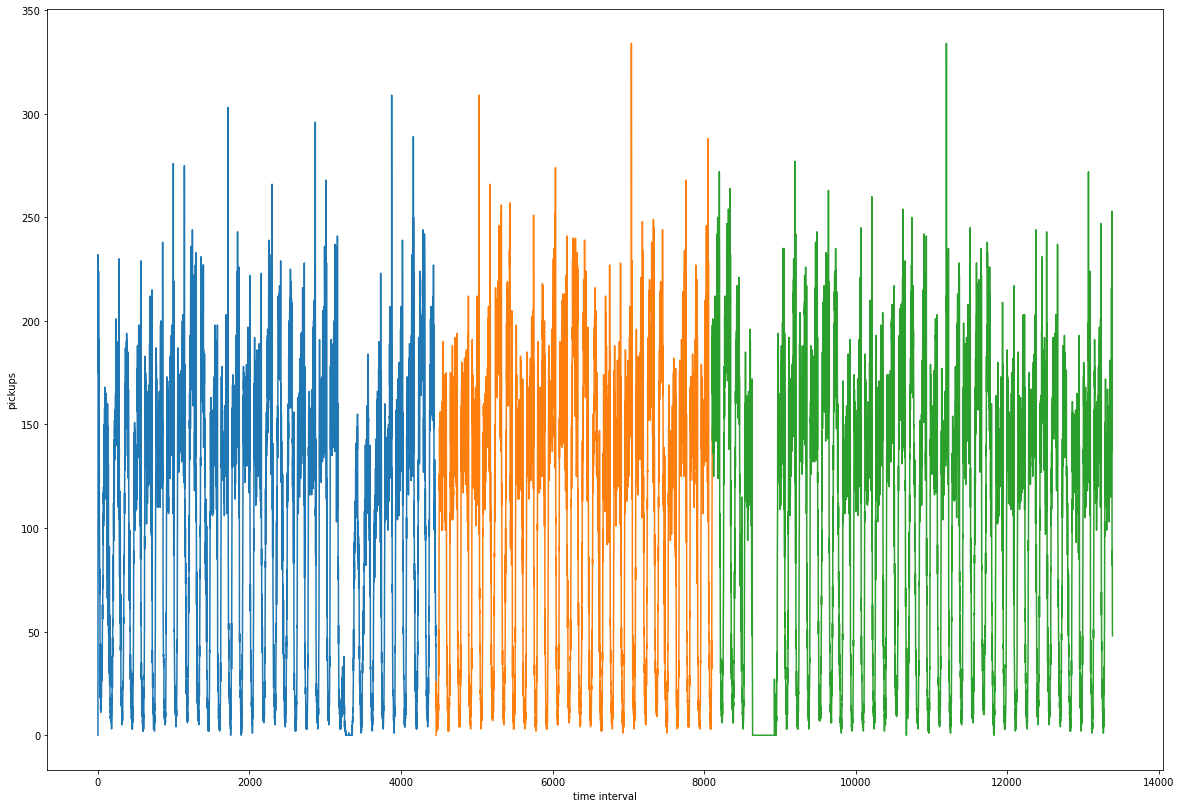

In [104]:
# we will represent time series data using the foriour transform method
# we plot the time series data of 1st reagion as to see how data is flactude in the each time bins
plt.figure(figsize=[20,14])
plt.plot(list(range(0,4464)),regions_cum[0][:4464])
plt.plot(list(range(4464,8109)),regions_cum[0][4464:8109])
plt.plot(list(range(8109,13392)),regions_cum[0][8109:])
plt.xlabel('time interval')
plt.ylabel('pickups')

Text(0, 0.5, 'pickups')

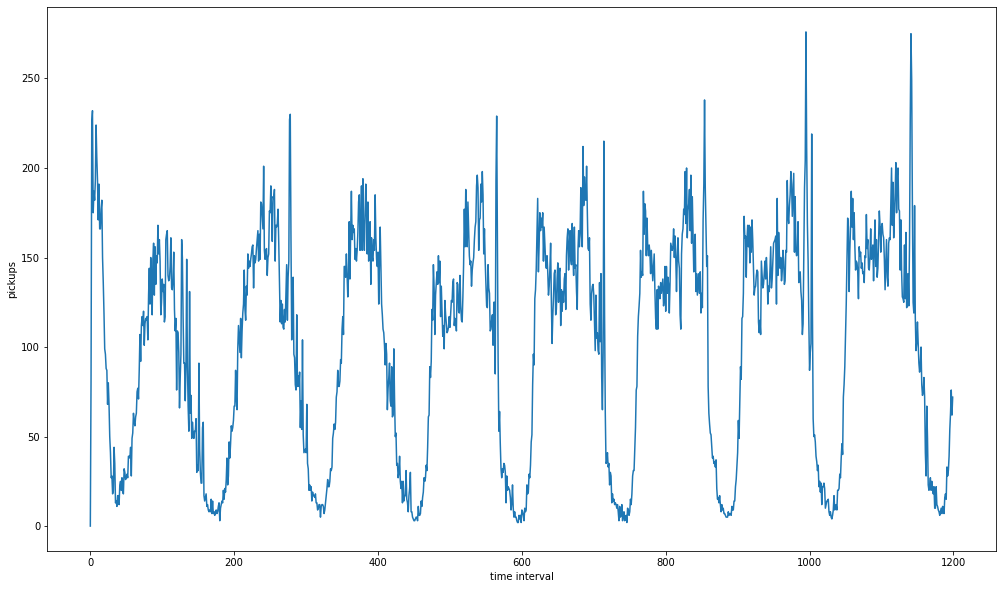

In [21]:
# for clearly explaination we zoom, and plot the foriour transform in 1200 bins of 10 min interval
plt.figure(figsize=[17,10])
plt.plot(list(range(1200)),regions_cum[0][:1200])
plt.xlabel('time interval')
plt.ylabel('pickups')
# here x axis represents the time bins of 10 min interval
# in 24hr = 1440 mins, 10min interval bins = 114
# so in 144 time inteval window, we have 24hr of time data

##### observations:
1. in the morning the pickups are quite decreases slowaly but at a time it will increasing quickly
2. moring pikups are occure b/w 150-200
3. In the evening time pickups is at its peak value, peakups crosses 250


So at this, we remove outliers, divide regions and create 10 min time interval binsn our data is fully prepared for the model building process.

# Model building

In [20]:
# we creating a new dataframe
ratios_jan = pd.DataFrame()
ratios_jan['Actual']=jan2015_smooth   # used in training part
ratios_jan['Prediction']=jan2016_smooth
ratios_jan['Ratios']=ratios_jan['Prediction']*1.0/ratios_jan['Actual']*1.0  # precision rate

In [23]:
ratios_jan.head()

,Actual,Prediction,Ratios
0,112,0,0.000000
1,112,81,0.723214
2,231,225,0.974026
3,235,232,0.987234
4,223,175,0.784753


In [181]:
# we are building baseline model wiht the different variations;
#baseline models: a baseline is a model that is both simple to set up and has a reasonable chance of providing decent results.
# the variations are the features by which we can flactuate the model accuracy
# The variations which we are using are:
# 1. Using ratio of jan2016 / jan2015 data
# 2. Using the predicted values fo jan2016, which we have created in new datafram

*****The first baseline model we are using *****
# Moving Averages 

Next observation is the mean of all past observations in a specific window size

### with Ratios variation

The Simple Moving Average (SMA) is calculated by adding the past ratios over a number of time periods and then dividing the sum by the number of time periods. The SMA is basically the average price of the given time period, with equal weighting given to the price of each period.

SMA = ( Sum ( Price, n ) ) / n    >>>>>>>> n is window size

In [21]:
# ratios is basically Ratio(t) = Pickup_2016(t) / Pickup_2015(t)
# we have to predict the pickups at 2016(t) so we have to calculate the ratio(t), when pickup_2015(t) is given
#  Rt=(Rt−1+Rt−2+Rt−3....Rt−n)/N..............N is hyperperameter(Window_size)
# here are are applying the simple moving average
import math
def SMV_ratio(frame):
    predicted_ratio = (frame.Ratios.values)[0]
    window_size = 1  # by applying multile value of window_size 1 gives best result among them
    predicted_values = []
    error = []
    for i in range(4464*25):
        if i%4464==0:
            error.append(0)  # error value per region.... append 0 in error... error size =  number of regions
            predicted_values.append(0)
            continue
        predicted_values.append(int((frame.Actual.values[i])*predicted_ratio))   # predicted value at time t+1
        error.append(abs(math.pow(int((frame.Actual.values[i])*predicted_ratio)-(frame.Prediction.values[i]),1)))
        if i+1>=window_size:
            predicted_ratio = sum(frame.Ratios.values[(i+1)-window_size:(i+1)]) / window_size
        else:
            predicted_ratio = sum(frame.Ratios.values[0:(i+1)]) / window_size
            
    map_error = (sum(error)/len(error))/(sum(frame.Prediction.values)/len(frame.Prediction.values))
    return map_error

result_SMV_ratio = SMV_ratio(ratios_jan)
result_SMV_ratio

0.4593812356017936

### with previous values variation

In [22]:
# we have to predict the pickups at 2016(t) so we have to calculate the ratio(t), when pickup_2015(t) is given
#  Pt=(Pt−1+Pt−2+Pt−3....+Pt−n)/N..............N is hyperperameter(Window_size)
# here are are applying the simple moving average
import math
def SMV_predicted(frame):
    predicted_ratio = (frame.Prediction.values)[0]
    window_size = 2   # by applying multile value of window_size 2 gives best result among them
    predicted_values = []
    error = []
    for i in range(4464*25):
        predicted_values.append(predicted_ratio)   # predicted value at time t+1
        error.append(abs((math.pow(predicted_ratio-(frame['Prediction'].values)[i],1))))
        
        if i+1>=window_size:
            predicted_ratio = int(sum(frame.Prediction.values[(i+1)-window_size:(i+1)]) / window_size)
        else:
            predicted_ratio = int(sum(frame.Prediction.values[0:(i+1)]) / (i+1))
            
    map_error = (sum(error)/len(error))/(sum(frame.Prediction.values)/len(frame.Prediction.values))
    return map_error

result_SMV_predicted = SMV_predicted(ratios_jan)
result_SMV_predicted

0.11615491516086505

In [112]:
# we are using weighted moveing average too but it will not gives the better,
# results as compare to moving average, now we are using exponential moving average.....

*****The second baseline model we are using *****
# Exponential Weighted Moving Averages 

### with ratio variation
R′t=α∗Rt−1+(1−α)∗R′t−1

In [23]:
def EWMV_ratios(frame):
    predicted_ratio=(frame['Ratios'].values)[0]
    alpha=0.2
    error=[]
    predicted_values=[]
    for i in range(0,4464*25):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(int(((frame.Actual.values)[i])*predicted_ratio))
        error.append(abs((math.pow(int(((frame.Actual.values)[i])*predicted_ratio)-(frame['Prediction'].values)[i],1))))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((frame['Ratios'].values)[i])
    
    mape_err = (sum(error)/len(error))/(sum(frame['Prediction'].values)/len(frame['Prediction'].values))
    return mape_err
result_EWMV_ratio = EWMV_ratios(ratios_jan)
result_EWMV_ratio

0.445088447542259

### with previous values variation
P′t=α∗Pt−1+(1−α)∗P′t−1

In [26]:
def EWMV_predicted(frame):
    predicted_value= (frame['Prediction'].values)[0]
    alpha=0.3
    error=[]
    predicted_values=[]
    for i in range(0,4464*25):
        if i%4464==0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((math.pow(predicted_value-(frame['Prediction'].values)[i],1))))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((frame['Prediction'].values)[i]))
    
    mape_err = (sum(error)/len(error))/(sum(frame['Prediction'].values)/len(frame['Prediction'].values))
    return mape_err,predicted_values

result_EWMV_predicted,val = EWMV_predicted(ratios_jan)
result_EWMV_predicted
val

[0,
 0,
 56,
 174,
 214,
 186,
 186,
 183,
 190,
 213,
 208,
 197,
 178,
 187,
 172,
 167,
 174,
 179,
 158,
 142,
 125,
 106,
 98,
 91,
 88,
 74,
 78,
 71,
 56,
 45,
 32,
 29,
 21,
 20,
 36,
 35,
 19,
 15,
 12,
 15,
 16,
 13,
 19,
 23,
 20,
 24,
 20,
 18,
 27,
 29,
 26,
 26,
 28,
 27,
 35,
 37,
 37,
 41,
 31,
 43,
 49,
 58,
 57,
 56,
 59,
 61,
 70,
 74,
 71,
 82,
 99,
 94,
 106,
 113,
 112,
 117,
 105,
 110,
 114,
 114,
 116,
 107,
 122,
 137,
 127,
 143,
 135,
 123,
 141,
 152,
 135,
 149,
 139,
 147,
 147,
 161,
 154,
 158,
 151,
 127,
 125,
 134,
 131,
 133,
 119,
 117,
 147,
 158,
 162,
 146,
 139,
 138,
 142,
 155,
 139,
 134,
 136,
 147,
 128,
 114,
 115,
 87,
 102,
 106,
 99,
 75,
 80,
 91,
 139,
 146,
 125,
 101,
 94,
 77,
 86,
 130,
 102,
 77,
 60,
 109,
 76,
 73,
 56,
 57,
 53,
 50,
 52,
 52,
 57,
 38,
 35,
 32,
 73,
 52,
 36,
 27,
 24,
 45,
 54,
 28,
 18,
 16,
 17,
 12,
 11,
 9,
 8,
 8,
 8,
 12,
 8,
 12,
 8,
 8,
 6,
 7,
 8,
 7,
 7,
 9,
 11,
 5,
 8,
 10,
 12,
 12,
 17,
 15,


In [25]:
# we comparing the mean absoluter persentage error of all the baseline models,
# checking which model gives the best MAPE in which variation
print('The mean absolute % error of simple_moving_avg_with_ratio: ',result_SMV_ratio)
print('The mean absolute % error of simple_moving_avg_with_previous: ',result_SMV_predicted)
print('The mean absolute % error of exponential_moving_avg_with_previous: ',result_EWMV_ratio)
print('The mean absolute % error of exponintial_moving_avg_with_previous: ',result_EWMV_predicted)


The mean absolute % error of simple_moving_avg_with_ratio:  0.4593812356017936
The mean absolute % error of simple_moving_avg_with_previous:  0.11615491516086505
The mean absolute % error of exponential_moving_avg_with_previous:  0.445088447542259
The mean absolute % error of exponintial_moving_avg_with_previous:  0.11324920265533439


In [ ]:
# we observe that the exponential moving average with,
# the previous values gives the lowest MEP error